In [3]:
using Pkg
include("./P2H_CapacityExpansion.jl")
cd("/cluster/home/danare/git")
Pkg.activate(".")
using .P2H_CapacityExpansion
using DataFrames
using Parameters
using Flux
using Surrogates
using ScikitLearn
using LinearAlgebra, Random, Statistics
using JuMP
using XLSX
using PlotlyJS
using Clustering
using CSV
using Dates
using PyCall
@pyimport joblib
using BSON
using StatsBase, MultivariateStats

  Activating project at `~/git`


## Read the Data

In [12]:
# read in the data
config = P2H_CapacityExpansion.read_yaml_file();
data = P2H_CapacityExpansion.load_cep_data(config=config);
ts_data = P2H_CapacityExpansion.load_timeseries_data_full(config=config);
gas_gen = [gen for (gen, props) ∈ config["techs"] if haskey(props, "input") && get(props["input"], "fuel", nothing) == "R_Gas"];

┌ Info: Each time-series is averaged in 3-hourly steps
└ @ Main.P2H_CapacityExpansion /cluster/home/danare/git/P2H_CapacityExpansion/utils/load_data.jl:76


In [13]:
dir = "/cluster/home/danare/git/P2H_CapacityExpansion/results/aggregated_results/"
file = "/cluster/home/danare/git/P2H_CapacityExpansion/results/500_scenarios.txt"

"/cluster/home/danare/git/P2H_CapacityExpansion/results/500_scenarios.txt"

# Read the Data

In [14]:
df_raw = P2H_CapacityExpansion.read_txt_file(file);

In [15]:
size(df_raw)

(628, 13)

# Iterate though the Models

In [7]:
models = Dict(
    "RandomForest" => P2H_CapacityExpansion.random_forest_sklearn,
    "DecisionTree" => P2H_CapacityExpansion.decision_tree_sklearn,
    "LinearRegression" => P2H_CapacityExpansion.linear_regression_sklearn,
    "NeuralNetwork" => P2H_CapacityExpansion.simple_neural_network_sklearn,
    "GaussianProcesses" => P2H_CapacityExpansion.gaussian_process,
    "SVR" => P2H_CapacityExpansion.svr_sklearn,
);

In [8]:
function kmeans_subset(X, n)
    R = kmeans(Matrix(X)', n) 
    idx = [findfirst(==(i), R.assignments) for i in 1:n]
    return idx
end

kmeans_subset (generic function with 1 method)

In [22]:

# read in the data
config = P2H_CapacityExpansion.read_yaml_file();
data = P2H_CapacityExpansion.load_cep_data(config=config);
ts_data = P2H_CapacityExpansion.load_timeseries_data_full(config=config);
gas_gen = [gen for (gen, props) ∈ config["techs"] if haskey(props, "input") && get(props["input"], "fuel", nothing) == "R_Gas"]

┌ Info: Each time-series is averaged in 3-hourly steps
└ @ Main.P2H_CapacityExpansion /cluster/home/danare/git/P2H_CapacityExpansion/utils/load_data.jl:76


2-element Vector{String}:
 "P_Gas_CCGT"
 "X_ATR_CCS"

In [ ]:
cep = P2H_CapacityExpansion.run_opt(ts_data=ts_data, data=data, config=config)
result = P2H_CapacityExpansion.optimize_and_output(cep=cep, config=config, data=data, ts_data=ts_data, name="_scenario", short_sol=true)
#3m33s

┌ Info: Reading the data ...
└ @ Main.P2H_CapacityExpansion /cluster/home/danare/git/P2H_CapacityExpansion/src/opt.jl:17
┌ Info: Setting up the optimization variables ...
└ @ Main.P2H_CapacityExpansion /cluster/home/danare/git/P2H_CapacityExpansion/src/opt.jl:20


In [9]:
stochastic_models = Set(["RandomForest", "NeuralNetwork", "DecisionTree"]);

In [11]:
step_size = 100
df_full = DataFrame(Method=String[],  Value=Float64[], Size=Int[]);
n_runs = 3

for n ∈ 100:step_size:size(df_raw)[1] 
    
    # clustering the entire subspace to identify n samples
    idx = kmeans_subset(select(df_raw, Not(:Cost)), n)
    df = df_raw[idx,:]

    ### split the data into test and training ###
    X_train, y_train, X_test, y_test = P2H_CapacityExpansion.partitionTrainTest(df, :Cost, 0.8)

    ### scale the data ###
    X_train_scaled, μX, σX  = P2H_CapacityExpansion.scaling(X_train)
    X_test_scaled = (X_test .- μX) ./ σX
    y_train_scaled, μy, σy  = P2H_CapacityExpansion.scaling(y_train)
    
    # remove np.nan #
    for i in eachindex(X_test_scaled)
        if isnan(X_test_scaled[i])
            X_test_scaled[i] = 0.0
        end
    end

    ### train ML model and compute R2 ### 
    for (name, fun) ∈ models
        # determine average for non-deterministic models
        iter = name ∈ stochastic_models ? n_runs : 1
        
        r2 = 0
        for k ∈ 1:iter
            sg = fun(X_train_scaled, y_train_scaled, X_test_scaled)
            ŷ_rescaled = sg.prediction .* σy .+ μy
            r2 += P2H_CapacityExpansion.r2_score(y_test, ŷ_rescaled)

            ### save the model ###
            if n == last(100:step_size:size(df_raw)[1]) && k == iter
                model = sg.model
                # assume model is trained with ScikitLearn.jl
                joblib.dump(model[:model], "$(dir)$(name).pkl")
            end
        end

        ### add to the df ### 
        push!(df_full, (Method = name, Value = r2/iter, Size = size(X_train)[1]))
    end 
end

Iteration 68, loss = 0.01569819
Iteration 69, loss = 0.01525565
Iteration 70, loss = 0.01521764
Iteration 71, loss = 0.01475422
Iteration 72, loss = 0.01478179
Iteration 73, loss = 0.01444561
Iteration 74, loss = 0.01396121
Iteration 75, loss = 0.01372459
Iteration 76, loss = 0.01356081
Iteration 77, loss = 0.01360341
Iteration 78, loss = 0.01330896
Iteration 79, loss = 0.01313113
Iteration 80, loss = 0.01309484
Iteration 81, loss = 0.01274517
Iteration 82, loss = 0.01280228
Iteration 83, loss = 0.01233258
Iteration 84, loss = 0.01216195
Iteration 85, loss = 0.01202949
Iteration 86, loss = 0.01172370
Iteration 87, loss = 0.01153841
Iteration 88, loss = 0.01174672
Iteration 89, loss = 0.01134232
Iteration 90, loss = 0.01118495
Iteration 91, loss = 0.01094761
Iteration 92, loss = 0.01090845
Iteration 93, loss = 0.01060558
Iteration 94, loss = 0.01052420
Iteration 95, loss = 0.01039175
Iteration 96, loss = 0.01068086
Iteration 97, loss = 0.01027306
Iteration 98, loss = 0.01009932
Iteratio

MethodError: MethodError: no method matching getindex(::DecisionTree.RandomForestRegressor, ::Symbol)

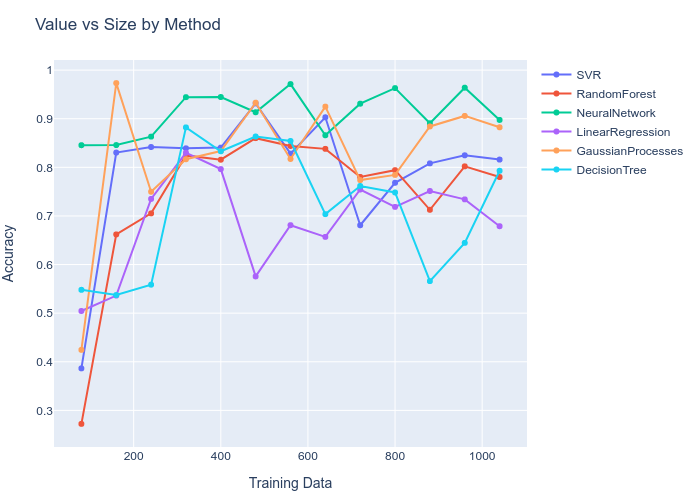

In [35]:
traces = AbstractTrace[]  # Correct type for individual traces
sort!(df_full, [:Method, :Size], rev=true)

for m in unique(df_full.Method)
    subdf = filter(:Method => ==(m), df_full)
    trace = scatter(
        x = subdf.Size,
        y = subdf.Value,
        mode = "lines+markers",
        name = string(m)
    )
    push!(traces, trace)
end

# Define the layout
layout = Layout(
    title = "Value vs Size by Method",
    xaxis_title = "Training Data",
    yaxis_title = "Accuracy"
)

# Create a single Plot from traces and layout
plt = plot(traces, layout)

# Show the plot
display(plt)

## Sub-sampling strategies

In [ ]:
files_list = filter(f -> endswith(f, ".txt"), readdir(dir, join=true));

In [ ]:
step_size = 50
df_full = DataFrame(Method=String[],  Value=Float64[], Size=Int[]);


### ALTERNATIVE 1: RANDOM SAMPLING ### 
for n in 140:step_size:size(df_raw)[1] #unique(ceil(Int, size(df_raw)[1]/n) for n in 140:step_size:size(df_raw)[1])
    df = df_raw[StatsBase.sample(1:nrow(df_raw), n; replace=false), :]
end

### ALTERNATIVE 2: EQUAL SELECTION SAMPLING ### 
for n in unique(ceil(Int, size(df_raw)[1]/n) for n in 140:step_size:size(df_raw)[1])
    df = df_raw[1:n:end, :]
    df = select(df, names(df)[[sum(df[!, col]) != 0 for col in names(df)]])
end

### ALTERNATIVE 3: LHS ### 
for f in files_list
    df = P2H_CapacityExpansion.read_txt_file(f)
end



# Read, normalize and transpose the df

In [ ]:
df_raw = P2H_CapacityExpansion.read_txt_file(file);
df_raw = select(df_raw, Not(:Cost))
m = Matrix(df_raw)
x_norm, μ, σ = P2H_CapacityExpansion.scaling(m)
X = x_norm'

# Derive PCs

In [ ]:
# generate PCA model
model = fit(PCA, X; maxoutdim=3)

In [ ]:
# transpose the data back again 
X_transform = MultivariateStats.transform(model, X)

In [ ]:
df_pca =   DataFrame(permutedims(X_transform), :auto)
df_pca.Cost = df_raw.Cost

In [ ]:
https://www.reddit.com/r/deeplearning/comments/14vnfe8/how_to_decrease_high_loss_values/
https://discourse.julialang.org/t/how-to-efficiently-and-precisely-fit-a-function-with-neural-networks/73726
https://stackoverflow.com/questions/59153248/why-is-my-neural-network-stuck-at-high-loss-value-after-the-first-epochs


In [ ]:
df_full = DataFrame(Method=String[],  Value=Float64[], Size=Int[]);

df = P2H_CapacityExpansion.read_txt_file(file);

### split the data into test and training ###
X_train, y_train, X_test, y_test = P2H_CapacityExpansion.partitionTrainTest(df, :Cost, 0.7)

### scale the data ###
X_train_scaled, μX, σX  = P2H_CapacityExpansion.scaling(X_train)
X_test_scaled = (X_test .- μX) ./ σX

    # remove np.nan #
for i in eachindex(X_test_scaled)
    if isnan(X_test_scaled[i])
        X_test_scaled[i] = 0.0
    end
end
y_train_scaled, μy, σy  = P2H_CapacityExpansion.scaling(y_train)

### train ML model and compute R2 ### 
for (name,fun) ∈ models
    sg = fun(X_train_scaled, y_train_scaled, X_test_scaled)
    ŷ_rescaled = sg.prediction .* σy .+ μy
    r2 = P2H_CapacityExpansion.r2_score(y_test, ŷ_rescaled)

    ### add to the df ### 
    push!(df_full, (Method = name, Value = r2, Size = size(X_train)[1]))
end


In [ ]:
df_full

In [ ]:
df_full = DataFrame(Method=String[],  Value=Float64[], Size=Int[]);

df = df_pca

### split the data into test and training ###
X_train, y_train, X_test, y_test = P2H_CapacityExpansion.partitionTrainTest(df, :Cost, 0.7)

### scale the data ###
X_train_scaled, μX, σX  = P2H_CapacityExpansion.scaling(X_train)
X_test_scaled = (X_test .- μX) ./ σX

# remove np.nan #
for i in eachindex(X_test_scaled)
    if isnan(X_test_scaled[i])
        X_test_scaled[i] = 0.0
    end
end
y_train_scaled, μy, σy  = P2H_CapacityExpansion.scaling(y_train)

### train ML model and compute R2 ### 
for (name,fun) ∈ models
    sg = fun(X_train_scaled, y_train_scaled, X_test_scaled)
    ŷ_rescaled = sg.prediction .* σy .+ μy
    r2 = P2H_CapacityExpansion.r2_score(y_test, ŷ_rescaled)

    ### add to the df ### 
    push!(df_full, (Method = name, Value = r2, Size = size(X_train)[1]))
end

new sampling technique
iterate more often through the neural network

In [ ]:
df_full

In [ ]:
# Step 3: Loop through files with index

# Parameters
techs = setdiff([key for (key, val) ∈ config["techs"] if get(val, "inv", "")  == true], [key for (key, val) ∈ config["techs"] if get(val, "tech_group", "")  == "transmission"] ) 
years = config["year"]
scenarios = 1:length(txt_files)

# Column names
columns = [:scenario, :year, :cost] ∪ Symbol.(techs)

df = DataFrame(;
    :scenario => repeat(scenarios, inner=length(years)),
    :year => repeat(years, outer=length(txt_files)),
    :cost => fill(0.0, length(txt_files)*length(years)),
)

# Add technology columns, initialized to 0.0
for tech in techs
    df[!, Symbol(tech)] = fill(0.0, length(txt_files)*length(years))
end

## fill in the values
for file in txt_files
    lines = readlines(file)
    
    i = parse(Int64, split(split(file, "/")[end], "_")[1])

    # Parse technology capacities
    for line in lines
        if occursin("TotalCapacityAnnual", line)
            g = split(line, ",")[2]   
            if g in techs
                val = parse(Float64, strip(split(line, "=")[2]))
                y = parse(Int64, split(split(line, "]")[1], ",")[end])

                # insert into the dataframe
                idx = findfirst((df.year .== y) .& (df.scenario .== i))
                df[idx, Symbol(g)] = val
            end

        
        elseif occursin("COSTvar", line)
            y = parse(Int64, line[8:12])
            val = parse(Float64, strip(split(line, "=")[2]))
            # insert into the dataframe
            idx = findfirst((df.year .== y) .& (df.scenario .== i))
            df[idx, :cost] = val
        end
    end
end


In [ ]:
df_agg = df[:, Not(:year, :cost, :scenario)]
X = transpose(Matrix(df_agg))

In [ ]:
ub = [1.25, 620, 460, 300, 0.06, 0.93, 20]
lb = [0.75, 420, 260, 100, 0.015, 0.56, 13]


# Number of samples
n = 3

# Latin Hypercube Sampling
scenarios = Surrogates.sample(n,lb,ub, Surrogates.LatinHypercubeSample())

# 2. TRAIN THE MODEL #

In [ ]:
function perclass_splits(y, percent)
    uniq_class = unique(y)
    keep_index = []
    for class in uniq_class
        class_index = findall(y .== class)
        row_index = randsubseq(class_index, percent)
        push!(keep_index, row_index...)
    end
    return keep_index
end

In [ ]:
y = df[!, :cost]

# split data between train and test
Random.seed!(1)
train_index = perclass_splits(y, 0.67)
test_index = setdiff(1:length(y), train_index)

# spit features
X_train = X[:, train_index]
X_test = X[:, test_index]

# split classes
y_train = transpose(Array{Float64}(y[train_index]))
y_test = transpose(Array{Float64}(y[test_index]))

In [ ]:
model = Chain(
    Dense(12, 32, relu),
    Dense(32, 1)  # output: a single float
)

loss(x, y) = Flux.Losses.mse(model(x), y)  # or Flux.Losses.mae

In [ ]:
# track parameters
ps = Flux.params(model)
 # select an optimizer
learning_rate = 0.01
opt = ADAM(learning_rate)


In [ ]:
# train the model
loss_history = []

epochs = 500

for epoch in 1:epochs
    # train the model
    train!(loss, ps, [(X_train, y_train)], opt)
    # print report
    train_loss = loss(X_train, y_train)
    push!(loss_history, train_loss)
    println("Epoch = $epoch : Training loss = $train_loss")
end 

In [ ]:
# Step 1: Create a combined scenario-year column
df_long[!, :scenario_year] = string.(df_long.scenario, "_", df_long.year)

# Step 2: Pivot wide: rows = technology, columns = scenario_year, values = value
df_wide = unstack(df_long, :technology, :scenario_year, :value)

# Show the result as a matrix
X = Matrix(df_wide[:, Not(:technology)])
X = coalesce.(X, 0.0)
#https://medium.com/@mandarangchekar7/a-neural-network-explained-and-implemented-in-julia-1fbfe4aaf0df


In [ ]:
# make predictions
y_hat_raw = model(X_test)

In [ ]:
y_hat = onecold(y_hat_raw) .- 1
y = y_test_raw
mean(y_hat .== y)

In [ ]:
y_test